## Variational Autoencoder Model

In [1]:
# dependencies
from utils.paths import project_root
from dataloaders.sliding_window import LogsSlidingWindow
from utils.plots import plot_anomaly_detection_analysis

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import polars as pl
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd

import os

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, TimeSeriesSplit, ParameterGrid
import seaborn as sns

import itertools
import gc
import copy
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

/home/paulofr/miniforge3/envs/MLP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# configuration
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

assert pyro.__version__.startswith('1.9.1')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
smoke_test = 'CI' in os.environ

Using device: cuda


In [3]:
# loading and preparing the data
df = pl.read_csv(f"{project_root()}/data/parsed/cleaned_BGL_structured.csv")[['Timestamp', 'EventId', 'Label']]

# filter only logs without anomaly labels "-"
df = df.with_columns(
    (pl.col("Label") != "-").alias("Anomaly")
)

# convert Timestamp to polars Timestamp
df = df.with_columns(
    pl.from_epoch(pl.col("Timestamp"), time_unit="s").alias("Timestamp")
)

df.head()

Timestamp,EventId,Label,Anomaly
datetime[μs],str,str,bool
2005-06-03 22:42:50,"""3aa50e45""","""-""",false
2005-06-03 22:42:50,"""3aa50e45""","""-""",false
2005-06-03 22:42:50,"""3aa50e45""","""-""",false
2005-06-03 22:42:50,"""3aa50e45""","""-""",false
2005-06-03 22:42:50,"""3aa50e45""","""-""",false


In [4]:
# train test spit | TODO: ver se tem outra forma melhor de dividir
split_point = int(len(df) * 0.7)
train_df = df[:split_point]
test_df = df[split_point:]

In [5]:
# auxiliary functions to try load all data into vram or use batches
def get_available_vram_gb():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
        return free_mem / (1024**3)
    return 0

def estimate_tensor_size_gb(shape, dtype=torch.float32):
    bytes_per_element = torch.tensor([], dtype=dtype).element_size()
    total_elements = 1
    for dim in shape:
        total_elements *= dim
    return (total_elements * bytes_per_element) / (1024**3)

def precompute_windows(dataset):
    print(f"Pre-computing {len(dataset)} windows...")
    
    n_samples = len(dataset)
    input_dim = dataset.n_events
    
    X = torch.zeros((n_samples, input_dim), dtype=torch.float32)
    y = torch.zeros((n_samples,), dtype=torch.long)
    pred_types = torch.zeros((n_samples), dtype=torch.long)
    
    for i in tqdm(range(n_samples)):
        count_vec, label, pred_type = dataset[i]
        X[i] = count_vec
        y[i] = label
        pred_types[i] = pred_type
        
    print("Dataset converted to Tensor")
    return X, y, pred_types

In [6]:
# create datasets
def load_dataset(
        window_size='5m', 
        step_size='1m',
          n_prediction_window=3, 
          filter_strategy='label', 
          filter_params={'contamination': 0.01},
          batch_size = 4096
    ) -> dict:
    
    train_dataset = LogsSlidingWindow(
        df, 
        window_size=window_size,   
        step_size=step_size,
        n_prediction_window=n_prediction_window,
        filter_strategy=filter_strategy,
        filter_params=filter_params
    )

    train_event_ids = train_dataset.event_ids
    INPUT_DIM = train_dataset.n_events

    test_dataset = LogsSlidingWindow(
        test_df,
        window_size=window_size,
        step_size=step_size, 
        n_prediction_window=n_prediction_window,
        event_ids=train_event_ids,  # use same event IDs as training set
        filter_strategy='none' # keep all logs for evaluation 
    )

    X_train, y_train, pred_types_train = precompute_windows(train_dataset)
    X_test, y_test, pred_types_test = precompute_windows(test_dataset)

    available_vram = get_available_vram_gb()
    train_size_gb = estimate_tensor_size_gb(X_train.shape, X_train.dtype)
    test_size_gb = estimate_tensor_size_gb(X_test.shape, X_test.dtype)
    total_size_gb = train_size_gb + test_size_gb

    safety_factor = 1.4
    required_vram = total_size_gb * safety_factor

    print(f"Available VRAM: {available_vram:.2f} GB")
    print(f"Required VRAM: {required_vram:.2f} GB (train: {train_size_gb:.2f} GB, test: {test_size_gb:.2f} GB)")

    USE_VRAM = required_vram < available_vram
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == 'cuda' and USE_VRAM:
        print("Sufficient VRAM available - loading data to GPU")
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        print("Data is ready in VRAM.")
        return {
            "mode": "tensor",
            "device": device,
            "input_dim": INPUT_DIM,
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
            "pred_types_train": pred_types_train,
            "pred_types_test": pred_types_test,
        }
    
    print("Insufficient VRAM or unavailable GPU - using DataLoader")
    batch_size = batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=(device.type == "cuda"))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=(device.type == "cuda"))
    print(f"Train batches: {len(train_loader)}")
    print(f"Test batches: {len(test_loader)}")

    return {
        "mode": "dataloader",
        "device": device,
        "input_dim": INPUT_DIM,
        "train_dataset": train_dataset,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "pred_types_train": pred_types_train,
        "pred_types_test": pred_types_test,
    }


In [7]:
def get_vram_batches(X, batch_size=4096, shuffle=True):
    n_samples = X.shape[0]
    indices = torch.arange(n_samples, device=X.device)
    
    if shuffle:
        indices = torch.randperm(n_samples, device=X.device)
        
    for start_idx in range(0, n_samples, batch_size):
        batch_indices = indices[start_idx : start_idx + batch_size]
        yield X[batch_indices]

## Variational Autoencoder Neural Network

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_loc = nn.Linear(hidden_dim, z_dim)    # latent mean
        self.fc2_scale = nn.Linear(hidden_dim, z_dim)  # latent scale
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)

        hidden = self.activation(self.fc1(x))
        z_loc = self.fc2_loc(hidden)

        z_log_scale = self.fc2_scale(hidden)
        z_log_scale = torch.clamp(z_log_scale, min=-5, max=2)

        # we need positive scale, so we exponentiate the output
        z_scale = torch.exp(self.fc2_scale(hidden))

        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        
        # predicts the reconstructed value (mean)
        self.fc_loc = nn.Linear(hidden_dim, input_dim)
        
        # predicts the variance/scale
        self.fc_scale = nn.Linear(hidden_dim, input_dim)
        
        self.activation = nn.LeakyReLU(0.2)
        self.softplus = nn.Softplus()

    def forward(self, z):
        hidden = self.activation(self.fc1(z))
        
        # reconstructed Mean
        loc_img = self.softplus(self.fc_loc(hidden))
        
        # reconstructed variance/scale
        log_scale = self.fc_scale(hidden)
        log_scale = torch.clamp(log_scale, min=-5, max=2)  
        scale_img = torch.exp(log_scale)
        
        return loc_img, scale_img

In [9]:
class LogAnomalyVAE(nn.Module):
    def __init__(self, input_dim=390, z_dim=32, hidden_dim=128, use_cuda=False):
        super().__init__()
        self.encoder = Encoder(input_dim, z_dim, hidden_dim)
        self.decoder = Decoder(input_dim, z_dim, hidden_dim)
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        if use_cuda:
            self.cuda()
            
    def model(self, x):
        pyro.module("decoder", self.decoder)        
        with pyro.plate("data", x.shape[0]):
            # prior: normal N(0, 1)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            
            # sample latent Z
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # decode z -> predicted mean and variance for the logs
            recon_loc, recon_scale = self.decoder(z)
            
            # observe 'x' (the real log-counts)
            pyro.sample("obs", dist.Normal(recon_loc, recon_scale).to_event(1), 
                        obs=x.reshape(-1, self.input_dim))

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use encoder to guess Z
            z_loc, z_scale = self.encoder(x)
            
            # sample Z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def get_anomaly_score(self, x, n_samples=10):
        x = x.to(next(self.parameters()).device)
        
        z_loc, z_scale = self.encoder(x)
        q_z = dist.Normal(z_loc, z_scale)
        
        # Sample multiple z's at once [n_samples, batch_size, z_dim]
        z = q_z.rsample((n_samples,))
        
        # Decode all samples [n_samples * batch_size, input_dim]
        z_flat = z.reshape(-1, self.z_dim)
        recon_loc, recon_scale = self.decoder(z_flat)
        
        # Reshape to [n_samples, batch_size, input_dim]
        recon_loc = recon_loc.reshape(n_samples, x.shape[0], -1)
        recon_scale = recon_scale.reshape(n_samples, x.shape[0], -1)
        
        # Reconstruction log likelihood: log p(x|z)
        x_expanded = x.reshape(1, x.shape[0], -1).expand(n_samples, -1, -1)
        log_p_x_given_z = dist.Normal(recon_loc, recon_scale).log_prob(x_expanded).sum(dim=-1)
        
        # KL divergence: KL(q(z|x) || p(z)) where p(z) = N(0, I)
        prior = dist.Normal(
            torch.zeros_like(z_loc), 
            torch.ones_like(z_scale)
        )
        kl_div = torch.distributions.kl_divergence(q_z, prior).sum(dim=-1)
        
        # ELBO = E[log p(x|z)] - KL(q(z|x) || p(z))
        # Anomaly score = -ELBO (higher = more anomalous)
        elbo = log_p_x_given_z.mean(dim=0) - kl_div
        
        return -elbo

## Training and Evaluating

In [20]:
def train_vae(
    vae,
    data,
    num_epochs=150,
    batch_size=4096,
    lr=1e-3,
    debug=False
):
    pyro.clear_param_store()

    optimizer = Adam({"lr": lr})
    svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

    epoch_losses = []
    epoch_iter = range(num_epochs)
    if debug:
        epoch_iter = tqdm(epoch_iter, desc="Training VAE", leave=True)


    for epoch in epoch_iter:
        epoch_loss = 0.0
        num_samples = 0

        if data["mode"] == "tensor":
            X_train = data["X_train"]

            for x_batch in get_vram_batches(
                X_train,
                batch_size=batch_size,
                shuffle=True
            ):
                loss = svi.step(x_batch)
                epoch_loss += loss
                num_samples += x_batch.size(0)

        else:
            train_loader = data["train_loader"]
            device = data["device"]

            for x_batch, *_ in train_loader:
                x_batch = x_batch.to(device, non_blocking=True)
                loss = svi.step(x_batch)
                epoch_loss += loss
                num_samples += x_batch.size(0)

        avg_loss = epoch_loss / num_samples
        epoch_losses.append(avg_loss)

    vae.eval() 
    total_clean_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():
        if data["mode"] == "tensor":
             for x_batch in get_vram_batches(data["X_train"], batch_size=4096, shuffle=False):
                 total_clean_loss += svi.evaluate_loss(x_batch)
                 total_samples += x_batch.size(0)
        else:
             for x_batch, *_ in data["train_loader"]:
                 x_batch = x_batch.to(data["device"])
                 total_clean_loss += svi.evaluate_loss(x_batch)
                 total_samples += x_batch.size(0)

    if debug:
        final_clean_loss = total_clean_loss / total_samples
        print(f"Final Standardized Train Loss: {final_clean_loss:.4f}")

        plt.figure(figsize=(12, 8))
        plt.plot(epoch_losses, linewidth=2)
        plt.xlabel("Epoch")
        plt.ylabel("Average ELBO Loss")
        plt.title("VAE Training Loss")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return epoch_losses

In [21]:
def test_vae(
    vae,
    data,
    eval_batch_size=8192
):
    print("Starting evaluation...")
    vae.eval()

    all_scores = []
    all_labels = []

    with torch.no_grad():
        if data["mode"] == "tensor":
            X_test = data["X_test"]
            y_test = data["y_test"]

            num_samples = X_test.shape[0]

            for start_idx in range(0, num_samples, eval_batch_size):
                end_idx = min(start_idx + eval_batch_size, num_samples)

                x_batch = X_test[start_idx:end_idx]
                y_batch = y_test[start_idx:end_idx]

                scores = vae.get_anomaly_score(x_batch)

                all_scores.append(scores)
                all_labels.append(y_batch)

        else:
            test_loader = data["test_loader"]
            device = data["device"]

            for x_batch, y_batch, *_ in test_loader:
                x_batch = x_batch.to(device, non_blocking=True)

                scores = vae.get_anomaly_score(x_batch)

                all_scores.append(scores)
                all_labels.append(y_batch)

    scores = torch.cat(all_scores).cpu().numpy()
    labels = torch.cat(all_labels).cpu().numpy()

    print(f"Evaluation complete. Processed {len(scores)} samples.")

    return scores, labels

## Hyperparameter tuning (non-bayesian)

In [ ]:
def check_label_distribution(n_splits=5, gap_windows=5):
    data = load_dataset(
        window_size='5m',
        step_size='1m',
        n_prediction_window=3,
        filter_strategy='combined',
        filter_params={'contamination':0.01},
        batch_size=4096
    )
    labels = data['y_train']

    tscv = KFold(n_splits=n_splits)
    indices = np.arange(len(labels))
    
    print("\n=== Label Distribution Across Folds ===")
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(indices)):
        train_anomalies = labels[train_idx].sum()
        val_anomalies = labels[val_idx].sum()
        
        print(f"\nFold {fold_idx + 1}:")
        print(f"  Train: {train_anomalies}/{len(train_idx)} anomalies ({100*train_anomalies/len(train_idx):.2f}%)")
        print(f"  Val: {val_anomalies}/{len(val_idx)} anomalies ({100*val_anomalies/len(val_idx):.2f}%)")

#check_label_distribution()

In [ ]:
def tune_vae_hyperparameters(data, param_grid, n_splits=3, gap_windows=5):
    kf = KFold(n_splits=n_splits, shuffle=False)

    grid = ParameterGrid(param_grid)
    
    best_loss = float('inf')
    best_params = None
    device = data["device"]
    
    if data["mode"] == "tensor":
        X_all = data["X_train"] 
        total_samples = X_all.size(0)
        print(f"Using direct VRAM slicing on {total_samples} samples.")
        
    else:
        if "train_dataset" not in data:
            raise ValueError("In 'dataloader' mode, load_dataset must return 'train_dataset' for CV splitting.")
        dataset = data["train_dataset"]
        total_samples = len(dataset)
        print("Using DataLoader Subsets (Slower).")

    indices = np.arange(total_samples)

    # grid search
    for params in grid:
        print(f"\nTesting: {params}")
        fold_losses = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices)):
            pyro.clear_param_store()

            val_start = val_idx.min()
            val_end = val_idx.max()
            mask_safe = ~((train_idx >= val_start - gap_windows) & (train_idx <= val_end + gap_windows))
            train_idx_purged = train_idx[mask_safe]
            
            vae = LogAnomalyVAE(
                input_dim=data['input_dim'],
                z_dim=params['z_dim'],
                hidden_dim=params['hidden_dim'],
                use_cuda=(device.type == "cuda")
            )
            
            optimizer = Adam({"lr": params['lr']})
            svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
            
            if data["mode"] == "tensor":
                X_fold_train = X_all[train_idx_purged] 
                X_fold_val = X_all[val_idx]
                
                for epoch in range(params['epochs']):
                    epoch_loss = 0.0
                    num_samples = 0
                    
                    for x_batch in get_vram_batches(X_fold_train, params['batch_size'], shuffle=True):
                        loss = svi.step(x_batch)
                        epoch_loss += loss
                        num_samples += x_batch.size(0)
                    
                    if epoch == params['epochs']-1:
                        avg_epoch_loss = epoch_loss / num_samples
                        print(f"--- Fold {fold_idx+1} Final epoch training loss: {avg_epoch_loss:.2f}")
                        
                # Evaluate validation loss
                val_loss = 0.0
                val_samples = 0
                for x_val_batch in get_vram_batches(X_fold_val, batch_size=4096, shuffle=False):
                    val_loss += svi.evaluate_loss(x_val_batch)
                    val_samples += x_val_batch.size(0)
                
                avg_val_loss = val_loss / val_samples

            else:
                train_sub = Subset(dataset, train_idx_purged)
                val_sub = Subset(dataset, val_idx)
                
                train_loader = DataLoader(train_sub, batch_size=params['batch_size'], shuffle=True, num_workers=0)
                val_loader = DataLoader(val_sub, batch_size=4096, shuffle=False, num_workers=0)
                
                for epoch in range(params['epochs']):
                    epoch_loss = 0.0
                    num_samples = 0
                    for x_batch, *_ in train_loader:
                        x_batch = x_batch.to(device)
                        loss = svi.step(x_batch)  # ✅ FIX: Capture the return value
                        epoch_loss += loss
                        num_samples += x_batch.size(0)

                    if epoch == params['epochs']-1:
                        avg_epoch_loss = epoch_loss / num_samples
                        print(f"--- Fold {fold_idx+1} Final epoch training loss: {avg_epoch_loss:.2f}")
                        
                val_loss = 0.0
                val_samples = 0
                for x_batch, *_ in val_loader:
                    x_batch = x_batch.to(device)
                    val_loss += svi.evaluate_loss(x_batch)
                    val_samples += x_batch.size(0)
                
                avg_val_loss = val_loss / val_samples

            fold_losses.append(avg_val_loss)
            print(f"--- Fold {fold_idx+1} Validation loss: {avg_val_loss:.2f}")

        median_loss = np.median(fold_losses)
        print(f"-> Median CV loss: {median_loss:.4f}")
        
        if median_loss < best_loss:
            best_loss = median_loss
            best_params = params

    print(f"\nWINNER: {best_params} (Loss: {best_loss:.4f})")
    return best_params, best_loss

In [ ]:
def run_nested_grid_search(df, test_df, dataset_grid, model_grid, full_training_epochs=120):
    results = []    
    keys, values = zip(*dataset_grid.items())
    ds_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"total dataset configurations: {len(ds_combinations)}")
    
    for i, ds_params in enumerate(ds_combinations):
        print(f"\n{'='*50}")
        print(f"OUTER LOOP {i+1}/{len(ds_combinations)}")
        print(f"params: {ds_params}")
        print(f"{'='*50}")
        
        data = None
        vae = None
    
        try:
            data = load_dataset(
                window_size=ds_params['window_size'],
                step_size=ds_params['step_size'],
                n_prediction_window=ds_params['n_prediction_window'],
                filter_strategy=ds_params['filter_strategy'],
                filter_params=ds_params['filter_params'],
                batch_size=4096
            )
            
            if data['mode'] == 'tensor':
                n_pred = ds_params['n_prediction_window']
                w_mins = int(ds_params['window_size'].replace('m','')) # assuming 'm' format
                s_mins = int(ds_params['step_size'].replace('m',''))
                
                window_indices = w_mins // s_mins
                gap_indices = window_indices + n_pred
            else:
                ds = data['train_dataset']
                gap_seconds = ds.window_size.total_seconds() + ds.prediction_horizon.total_seconds()
                step_seconds = ds.step_size.total_seconds()
                gap_indices = int(gap_seconds / step_seconds)

            print("-- running inner CV for model params...")
            best_model_params, best_cv_loss = tune_vae_hyperparameters(
                data, 
                model_grid, 
                n_splits=5, 
                gap_windows=gap_indices
            )
                        
            print("-- retraining best model on full")
            vae = LogAnomalyVAE(
                input_dim=data['input_dim'],
                z_dim=best_model_params['z_dim'],
                hidden_dim=best_model_params['hidden_dim'],
                use_cuda=(data["device"].type == "cuda")
            )
            
            train_vae(
                vae, 
                data, 
                num_epochs=full_training_epochs, 
                batch_size=best_model_params['batch_size'],
                lr=best_model_params['lr']
            )
            
            print("-- evaluating on test set...")
            scores, labels = test_vae(vae, data, eval_batch_size=8192)
            
            roc = roc_auc_score(labels, scores)
            pr_auc = average_precision_score(labels, scores)
            
            print(f"--> RESULT: ROC AUC: {roc:.4f} | PR AUC: {pr_auc:.4f}")
            
            results.append({
                **ds_params,
                **best_model_params,
                'cv_reconstruction_loss': best_cv_loss,
                'test_roc_auc': roc,
                'test_pr_auc': pr_auc
            })
            
        except Exception as e:
            print(f"CRASHED on config {ds_params} !!!")
            print(e)
            import traceback
            traceback.print_exc()
            
        finally:            
            if vae is not None: del vae
            if data is not None: del data
            gc.collect()
            torch.cuda.empty_cache()
                
    return pd.DataFrame(results)

In [ ]:
dataset_grid = {
    'window_size': ['5m', '10m', '30m'],
    'step_size': ['1m'],
    'n_prediction_window': [3, 6, 12],
    'filter_strategy': ['label','combined'],
    'filter_params': [{'contamination': 0.01}, {'contamination': 0.05}]
}

model_grid = {
    'z_dim': [16, 32, 64],
    'hidden_dim': [64, 128, 256],
    'lr': [1e-3],
    'batch_size': [4096],
    'epochs': [30]
}

df_results = run_nested_grid_search(df, test_df, dataset_grid, model_grid)

Sorted 4713493 rows by timestamp
Found 390 unique event types
Prediction Horizon: +0:01:00 beyond current window
Checking for failures in the next 1 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2006-01-04 16:00:05
Generated 309188 sliding windows
Building index...
Index built. Shape: (309188, 3)
Isolation Forest: Removed 3091 windows (1.0%)
Remaining windows: 306097
Sorted 1414048 rows by timestamp
Found 390 unique event types
Prediction Horizon: +0:01:00 beyond current window
Checking for failures in the next 1 sliding windows.
Period -> Start time: 2005-08-30 05:28:32, End time: 2006-01-04 16:00:05
Generated 183502 sliding windows
Building index...
Index built. Shape: (183502, 3)
Pre-computing 306097 windows...


100%|██████████| 306097/306097 [00:28<00:00, 10737.72it/s]


Dataset converted to Tensor
Pre-computing 183502 windows...


100%|██████████| 183502/183502 [00:11<00:00, 16334.10it/s]


Dataset converted to Tensor
Available VRAM: 14.74 GB
Required VRAM: 1.00 GB (train: 0.44 GB, test: 0.27 GB)
Sufficient VRAM available - loading data to GPU
Data is ready in VRAM.


Training VAE: 100%|██████████| 120/120 [00:31<00:00,  3.79it/s]

Final Standardized Train Loss: -1535.8303


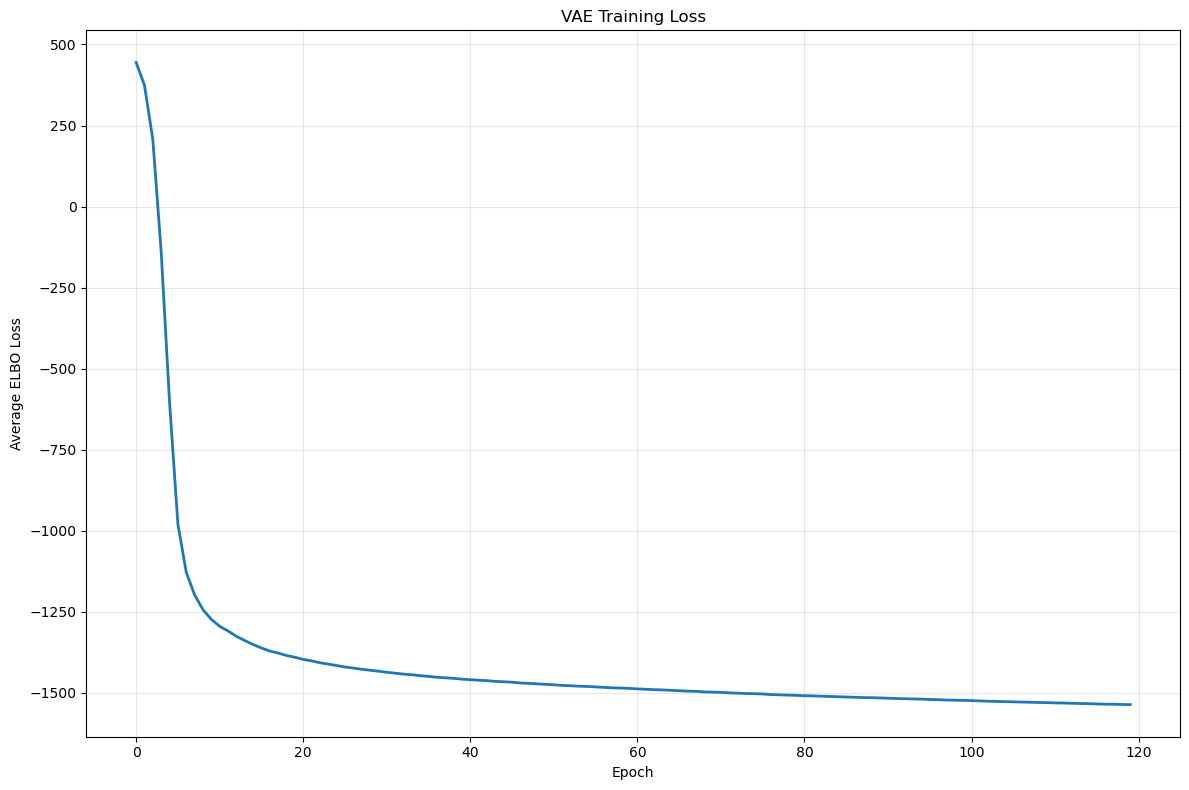

Starting evaluation...
Evaluation complete. Processed 183502 samples.


' alguns testados decentes\ndata = load_dataset(\n    window_size=\'5m\',\n    step_size=\'1m\',\n    n_prediction_window=1,\n    filter_strategy=\'combined\',#\'combined\',\n    filter_params={\'contamination\':0.1},\n    batch_size=4096\n)\n\ndata = load_dataset(\n    window_size=\'5m\',\n    step_size=\'1m\',\n    n_prediction_window=1,\n    filter_strategy=\'combined\',\n    filter_params={\'contamination\':0.05},\n    batch_size=4096\n)\n\nvae = LogAnomalyVAE(\n    input_dim=data[\'input_dim\'],\n    z_dim=64,\n    hidden_dim=256,\n    use_cuda=(data["device"].type == "cuda")\n)\n-158 media\n\ndata = load_dataset(\n    window_size=\'5m\',\n    step_size=\'1m\',\n    n_prediction_window=1,\n    filter_strategy=\'combined\',\n    filter_params={\'contamination\':0.01},\n    batch_size=4096\n)\n\nvae = LogAnomalyVAE(\n    input_dim=data[\'input_dim\'],\n    z_dim=64,\n    hidden_dim=256,\n    use_cuda=(data["device"].type == "cuda")\n)\n\ntrain_vae(\n    vae,\n    data,\n    num_epoc

In [23]:
data = load_dataset(
    window_size='10m',
    step_size='1m',
    n_prediction_window=1,
    filter_strategy='combined',
    filter_params={'contamination':0.01},
    batch_size=4096
)

vae = LogAnomalyVAE(
    input_dim=data['input_dim'],
    z_dim=32,
    hidden_dim=128,
    use_cuda=(data["device"].type == "cuda")
)

train_vae(
    vae,
    data,
    num_epochs=120,
    batch_size=4096,
    lr=1e-4,
    debug=True
)

scores, labels = test_vae(
    vae,
    data,
    eval_batch_size=8192
)

pred_types = data['pred_types_test']

''' alguns testados decentes
data = load_dataset(
    window_size='5m',
    step_size='1m',
    n_prediction_window=1,
    filter_strategy='combined',#'combined',
    filter_params={'contamination':0.1},
    batch_size=4096
)

data = load_dataset(
    window_size='5m',
    step_size='1m',
    n_prediction_window=1,
    filter_strategy='combined',
    filter_params={'contamination':0.05},
    batch_size=4096
)

vae = LogAnomalyVAE(
    input_dim=data['input_dim'],
    z_dim=64,
    hidden_dim=256,
    use_cuda=(data["device"].type == "cuda")
)
-158 media

data = load_dataset(
    window_size='5m',
    step_size='1m',
    n_prediction_window=1,
    filter_strategy='combined',
    filter_params={'contamination':0.01},
    batch_size=4096
)

vae = LogAnomalyVAE(
    input_dim=data['input_dim'],
    z_dim=64,
    hidden_dim=256,
    use_cuda=(data["device"].type == "cuda")
)

train_vae(
    vae,
    data,
    num_epochs=120,
    batch_size=4096,
    lr=1e-4
)
-1292 media

data = load_dataset(
    window_size='10m',
    step_size='1m',
    n_prediction_window=1,
    filter_strategy='combined',
    filter_params={'contamination':0.01},
    batch_size=4096
)

vae = LogAnomalyVAE(
    input_dim=data['input_dim'],
    z_dim=64,
    hidden_dim=256,
    use_cuda=(data["device"].type == "cuda")
)

train_vae(
    vae,
    data,
    num_epochs=120,
    batch_size=4096,
    lr=1e-4
)
-1020 media com PR AUC .99
'''

True

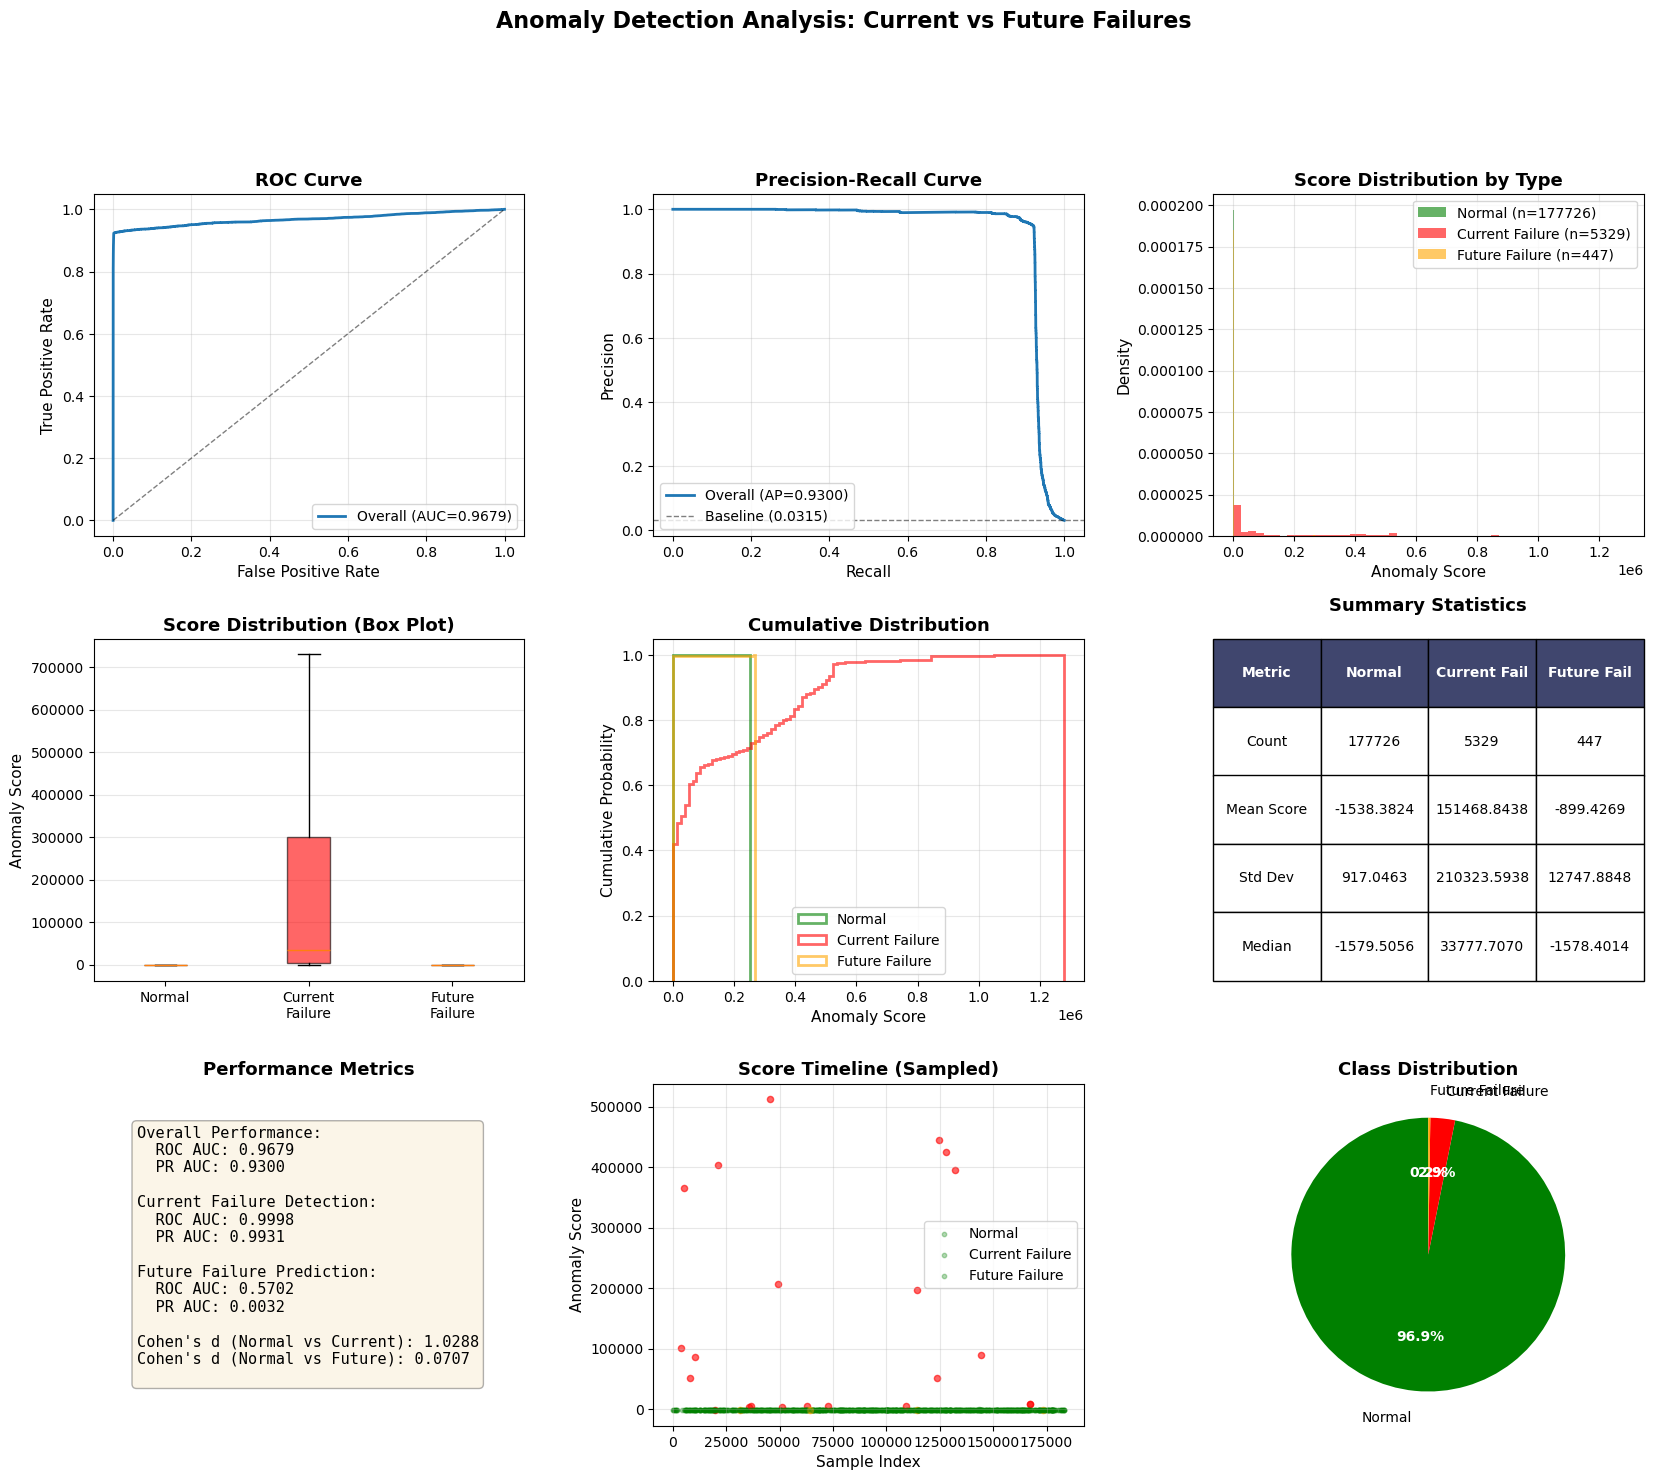

In [24]:
plot_anomaly_detection_analysis(scores, labels, pred_types)
True